In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
# === SIMULATION PARAMETERS (User-Configurable) ===
# Masses of the three bodies
M1 = 1.0
M2 = 1.0
M3 = 1.0

# Gravitational Constant (G)
G = 0.5

# Simulation Time Step (determines resolution and speed)
DT = 0.005

# Number of steps per frame update (controls animation speed vs. calculation load)
STEPS_PER_FRAME = 10

# Maximum number of time steps to keep in the path history (for optimization)
HISTORY_LIMIT = 5000

# === CLASS DEFINITIONS ===

In [4]:
class Body:
    """Represents a single mass in the N-body system."""
    def __init__(self, name, mass, position, velocity=None):
        self.name = name
        self.mass = mass
        # Position vector (x, y)
        self.r = np.array(position, dtype=float)
        # Velocity vector (vx, vy). Assumes initial velocity is zero if not provided.
        self.v = np.array(velocity, dtype=float) if velocity is not None else np.array([0.0, 0.0])
        # To store the historical path
        self.history = [self.r.copy()]

    def update_state(self, total_force, dt):
        """Updates position and velocity based on net force and time step (Semi-implicit Euler)."""
        # 1. Calculate acceleration (a = F / m)
        acceleration = total_force / self.mass

        # 2. Update velocity (v_new = v_old + a * dt)
        self.v += acceleration * dt

        # 3. Update position (r_new = r_old + v_new * dt)
        self.r += self.v * dt

        # 4. Record new position
        self.history.append(self.r.copy())
        # Keep history list manageable
        if len(self.history) > HISTORY_LIMIT:
            self.history.pop(0)

class ThreeBodySimulator:
    """Manages the simulation state and dynamics of the three bodies."""
    def __init__(self, body1, body2, body3, G_const):
        self.bodies = [body1, body2, body3]
        self.G = G_const
        self.time = 0.0

    def calculate_force_on(self, body_i, body_j):
        """Calculates the gravitational force vector exerted by body_j on body_i."""
        # Vector from body_i to body_j
        r_vector = body_j.r - body_i.r

        # Distance between the bodies
        r = np.linalg.norm(r_vector)

        if r == 0:
            # Avoid division by zero if bodies collide/overlap
            return np.array([0.0, 0.0])

        # Gravitational force magnitude: F = G * (m1 * m2) / r^2
        magnitude = (self.G * body_i.mass * body_j.mass) / (r**2)

        # Force direction: a unit vector in the direction of r_vector
        direction = r_vector / r

        # Force vector: F = magnitude * direction
        force_vector = magnitude * direction

        return force_vector

    def step(self, dt):
        """Performs one simulation step."""
        forces = []
        for i in range(3):
            net_force = np.array([0.0, 0.0])
            for j in range(3):
                if i != j:
                    # Sum the force exerted by body j on body i
                    net_force += self.calculate_force_on(self.bodies[i], self.bodies[j])
            forces.append(net_force)

        # Update position and velocity of each body after calculating all forces
        for i in range(3):
            self.bodies[i].update_state(forces[i], dt)

        self.time += dt

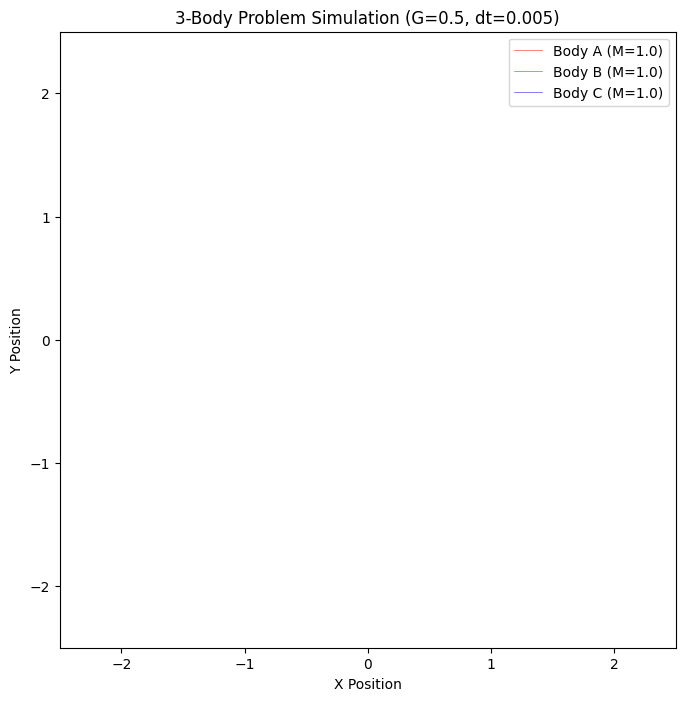

In [5]:
# === INITIALIZATION AND RUNNING ===

# Define initial positions (Equilateral Triangle for a dynamic start)
pos1 = [1.0, 0.0]
pos2 = [-0.5, np.sqrt(3)/2]
pos3 = [-0.5, -np.sqrt(3)/2]

# Initial velocity is zero for all bodies, as requested
vel = [0.0, 0.0]

body_A = Body("A", M1, pos1, vel)
body_B = Body("B", M2, pos2, vel)
body_C = Body("C", M3, pos3, vel)

simulator = ThreeBodySimulator(body_A, body_B, body_C, G)

# --- MATPLOTLIB SETUP ---
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title(f"3-Body Problem Simulation (G={G}, dt={DT})")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_aspect('equal', adjustable='box')

# Initial plot limits (adjust based on expected range)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)

# Setup for the current position points (markers)
body_points, = ax.plot([], [], 'o', markersize=10)

# Setup for the historical paths (lines)
# Note: Using plt.plot() returns a list of line objects, even for a single line
path_A, = ax.plot([], [], 'r-', linewidth=0.5, alpha=0.7, label=f"Body A (M={M1})")
path_B, = ax.plot([], [], 'g-', linewidth=0.5, alpha=0.7, label=f"Body B (M={M2})")
path_C, = ax.plot([], [], 'b-', linewidth=0.5, alpha=0.7, label=f"Body C (M={M3})")

paths = [path_A, path_B, path_C]
colors = ['r', 'g', 'b']
markers = ['o', 's', '^']

ax.legend()
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

In [6]:
def init_plot():
    """Initialization function for the animation."""
    # Reset all data
    body_points.set_data([], [])
    for path in paths:
        path.set_data([], [])
    time_text.set_text('')
    return [body_points, path_A, path_B, path_C, time_text]


def update_plot(frame):
    """Update function called at each animation frame."""
    
    # 1. Step the simulation multiple times for faster apparent animation
    for _ in range(STEPS_PER_FRAME):
        simulator.step(DT)

    # 2. Update the current positions (markers)
    x_positions = [body.r[0] for body in simulator.bodies]
    y_positions = [body.r[1] for body in simulator.bodies]
    body_points.set_data(x_positions, y_positions)
    body_points.set_color(colors)
    body_points.set_marker(markers)

    # 3. Update the historical paths (lines)
    for i, body in enumerate(simulator.bodies):
        history_array = np.array(body.history)
        paths[i].set_data(history_array[:, 0], history_array[:, 1])

    # 4. Update the time display
    time_text.set_text(f'Time: {simulator.time:.2f} s')
    
    # 5. Dynamic Plot Limits (keeps the bodies in view)
    all_x = np.concatenate([np.array(body.history)[:, 0] for body in simulator.bodies])
    all_y = np.concatenate([np.array(body.history)[:, 1] for body in simulator.bodies])
    
    # Only update limits if there is data
    if all_x.size > 0 and all_y.size > 0:
        x_min, x_max = all_x.min(), all_x.max()
        y_min, y_max = all_y.min(), all_y.max()

        x_range = x_max - x_min
        y_range = y_max - y_min
        max_range = max(x_range, y_range) * 1.2 # Add 20% buffer

        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2

        ax.set_xlim(x_center - max_range / 2, x_center + max_range / 2)
        ax.set_ylim(y_center - max_range / 2, y_center + max_range / 2)

    return [body_points, path_A, path_B, path_C, time_text]

In [7]:
if __name__ == '__main__':
    # Create the animation
    # interval=10 is roughly 100 FPS (1000ms / 10ms), adjust for smoother/faster refresh
    ani = FuncAnimation(
        fig,
        update_plot,
        frames=np.arange(0, 10000), # Run for a large number of frames
        init_func=init_plot,
        blit=True,
        interval=10 # Interval in milliseconds between frames
    )

    print("Running 3-Body Problem Simulation...")
    print(f"G: {G}, dt: {DT}, Steps/Frame: {STEPS_PER_FRAME}")
    plt.show()

Running 3-Body Problem Simulation...
G: 0.5, dt: 0.005, Steps/Frame: 10
